In [1]:
from pymonntorch import NeuronGroup, SynapseGroup, NeuronDimension, Recorder, Behavior, EventRecorder
import random
from conex import (
    Neocortex,
    prioritize_behaviors,
)
from conex.behaviors.neurons import (
    SimpleDendriteStructure,
    SimpleDendriteComputation,
    LIF,
    SpikeTrace,
    NeuronAxon,
    Fire,
    KWTA,
    ActivityBaseHomeostasis
)
from conex.behaviors.synapses import (
    SynapseInit,
    WeightInitializer,
    SimpleDendriticInput,
    Conv2dDendriticInput,
    LateralDendriticInput,
    AveragePool2D,
    SimpleSTDP,
    Conv2dSTDP,
    WeightClip
)
from conex.helpers.filters import (
    DoGFilter,
    GaborFilter
)
from conex.helpers.transforms.encoders import(
    Intensity2Latency,
    SimplePoisson
)
from conex.helpers.transforms.misc import(
    Conv2dFilter
)
import torch
import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import poisson
import plotly.graph_objects as go
import plotly.express as px
import torch.nn.functional as F
import numpy as np

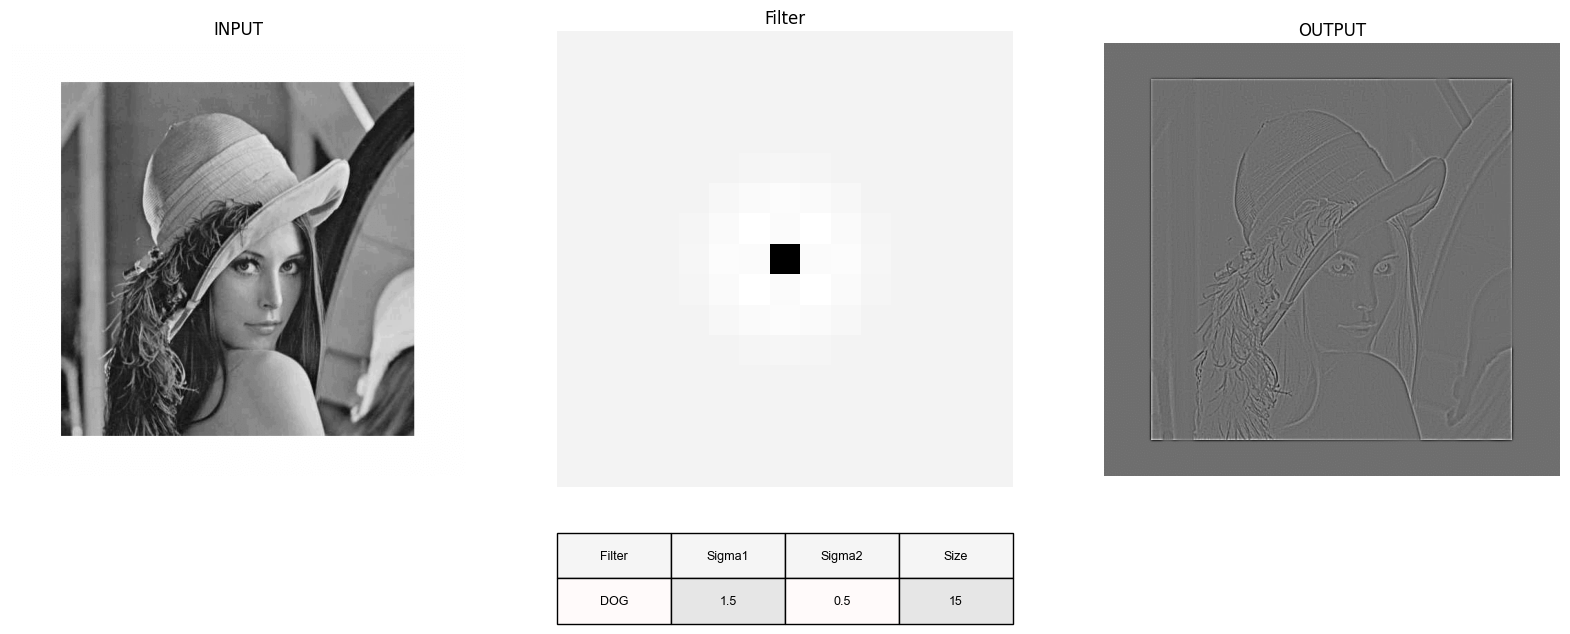

In [2]:
# dog filter
image = plt.imread("lena.jpg")
image = torch.tensor(image, dtype=torch.float32).mean(2) 
image = image / image.max()

S1 = 1.5
S2 = 0.5
SIZE = 15

dog_filter = DoGFilter(size = SIZE, sigma_1 = S1, sigma_2 = S2,zero_mean=True, one_sum=True ,device="cpu", dtype=torch.float32)
conv = Conv2dFilter(dog_filter.unsqueeze(0).unsqueeze(0), stride=1, padding=0)
filtered_image_dog = conv(image.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)

figure, axis = plt.subplots(1, 3, figsize=(20,20)) 
for ax in axis:
    ax.axis('off')
axis[2].imshow(filtered_image_dog, cmap="grey")
axis[2].set_title("OUTPUT")
axis[1].imshow(dog_filter, cmap="gray")
axis[1].set_title("Filter")
axis[0].imshow(image, cmap="gray")
axis[0].set_title("INPUT")



FONT = "arial"
parameters = ["Filter", "Sigma1", "Sigma2", "Size"]
values = ["DOG", S1, S2, SIZE]
table_data = [parameters, values]
table = axis[1].table(cellText = table_data, cellLoc = "center", loc = "bottom", bbox = [0, -0.3, 1, 0.2])
table.scale(0.8, 0.8)
table.auto_set_font_size(False)
table.set_fontsize(9)
for i in range(len(parameters)):
        table[(0, i)].set_facecolor("whitesmoke")
        table[(0, i)].set_text_props(color = 'black', fontfamily = FONT)

for i in range(len(values)):
        table[(1, i)].set_facecolor("snow" if i % 2 == 0 else '#e6e6e6')
        table[(1, i)].set_text_props(fontfamily = FONT)


plt.show()

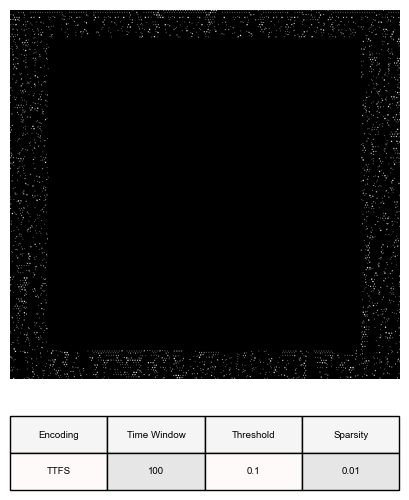

torch.Size([100, 615, 648])


In [4]:
# time to first spike of dog
TIME_WINDOW = 100
THRESHOLD = 0.1
SPARSITY = 0.01
encoder = Intensity2Latency(time_window=TIME_WINDOW, threshold=THRESHOLD, sparsity=SPARSITY)
spikes_on_center = encoder(filtered_image_dog)
FONT = "arial"
parameters = ["Encoding","Time Window", "Threshold", "Sparsity"]
values = ["TTFS",TIME_WINDOW, THRESHOLD, SPARSITY]
table_data = [parameters, values]
table = plt.table(cellText = table_data, cellLoc = "center", loc = "bottom", bbox = [0, -0.3, 1, 0.2])
table.scale(0.8, 0.8)
table.set_fontsize(9)
for i in range(len(parameters)):
        table[(0, i)].set_facecolor("whitesmoke")
        table[(0, i)].set_text_props(color = 'black', fontfamily = FONT)

for i in range(len(values)):
        table[(1, i)].set_facecolor("snow" if i % 2 == 0 else '#e6e6e6')
        table[(1, i)].set_text_props(fontfamily = FONT)

plt.axis('off')
plt.imshow(spikes_on_center.sum(0), cmap="gray")
plt.show()

print(spikes_on_center.shape) 
# raster plot 3d
fig = go.Figure(data=[go.Scatter3d(
    x=spikes_on_center.nonzero(as_tuple=True)[2],
    y=spikes_on_center.nonzero(as_tuple=True)[1],
    z=spikes_on_center.nonzero(as_tuple=True)[0],
    mode='markers',
    marker=dict(
        size=2,
        color='black',                
        colorscale='Viridis',
        opacity=0.8
    )
)])

fig.update_layout(scene = dict(
                    xaxis_title='X',
                    yaxis_title='Y',
                    zaxis_title='Time'),
                    width=700,
                    margin=dict(r=20, l=10, b=10, t=10))
fig.show()

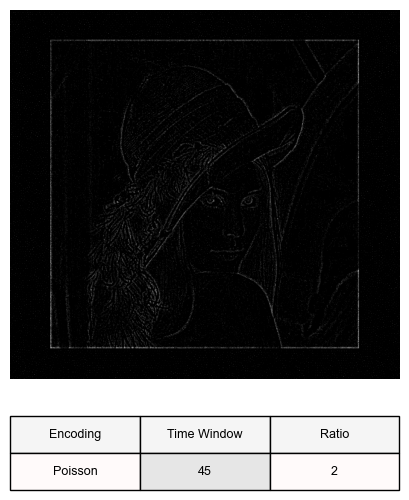

torch.Size([45, 614, 647])


In [4]:
# poisson dog

TIME_WINDOW = 45
RATIO = 2

encoder = SimplePoisson(time_window=TIME_WINDOW, ratio=RATIO)
spikes_on_center = encoder(filtered_image_dog)
plt.axis('off')
plt.imshow(spikes_on_center.sum(0), cmap="gray")

FONT = "arial"
parameters = ["Encoding","Time Window", "Ratio"]
values = ["Poisson",TIME_WINDOW, RATIO]
table_data = [parameters, values]
table = plt.table(cellText = table_data, cellLoc = "center", loc = "bottom", bbox = [0, -0.3, 1, 0.2])
table.scale(0.8, 0.8)
table.set_fontsize(9)
for i in range(len(parameters)):
        table[(0, i)].set_facecolor("whitesmoke")
        table[(0, i)].set_text_props(color = 'black', fontfamily = FONT)

for i in range(len(values)):
        table[(1, i)].set_facecolor("snow" if i % 2 == 0 else '#e6e6e6')
        table[(1, i)].set_text_props(fontfamily = FONT)

plt.show()

print(spikes_on_center.shape) 
# raster plot 3d 
fig = go.Figure(data=[go.Scatter3d(
    x=spikes_on_center.nonzero(as_tuple=True)[2],
    y=spikes_on_center.nonzero(as_tuple=True)[1],
    z=spikes_on_center.nonzero(as_tuple=True)[0],
    mode='markers',
    marker=dict(
        size=2,
        color='black',                
        colorscale='Viridis',
        opacity=0.8
    )
)])

fig.update_layout(scene = dict(
                    xaxis_title='X',
                    yaxis_title='Y',
                    zaxis_title='Time'),
                    width=700,
                    margin=dict(r=20, l=10, b=10, t=10))
fig.show()


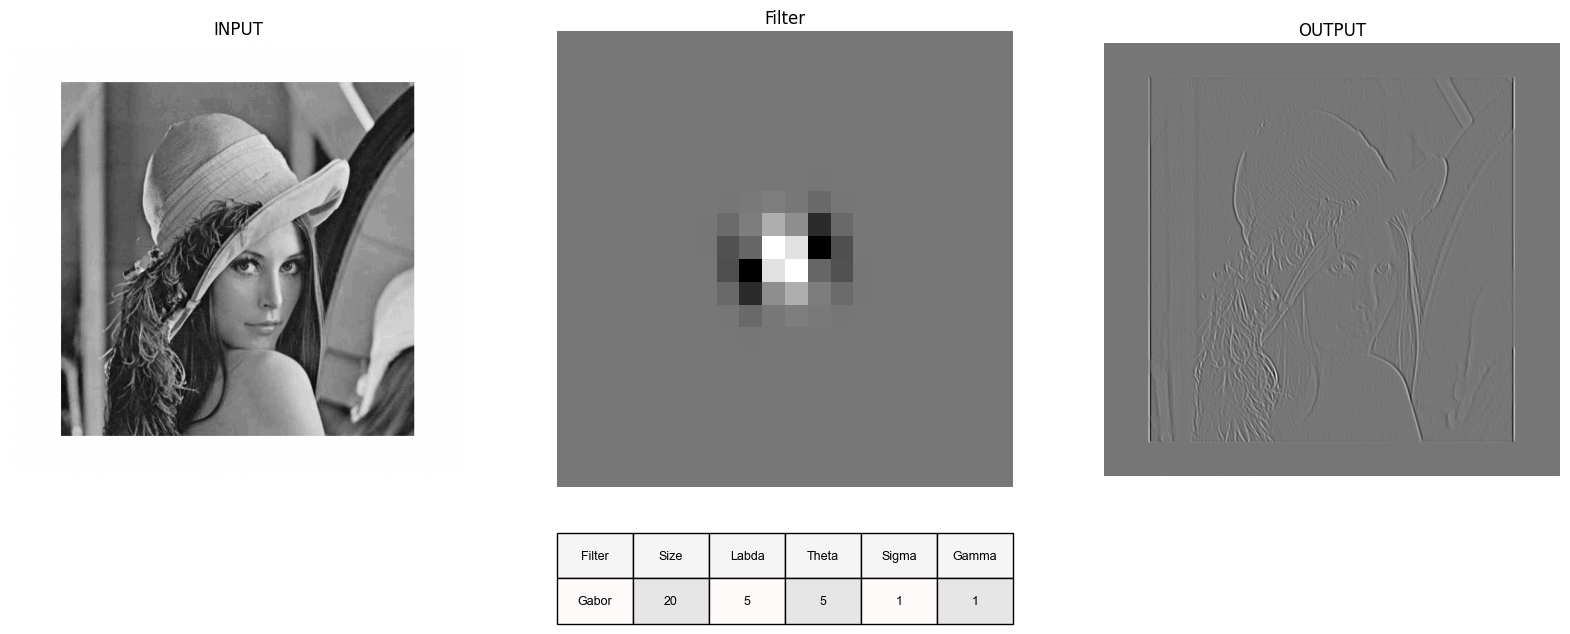

In [6]:
# gabor filter
image = plt.imread("lena.jpg")
image = torch.tensor(image, dtype=torch.float32).mean(2)
image = image / image.max()


# generate parameters for gabor filter
SIZE = 20
LABDA = 5
THETA = 5
SIGMA = 1
GAMMA = 1



gabor_filter = GaborFilter(size = SIZE, labda = LABDA, theta = THETA, sigma = SIGMA, gamma = GAMMA, device="cpu", dtype=torch.float32, zero_mean=True, one_sum=True)
conv = Conv2dFilter(gabor_filter.unsqueeze(0).unsqueeze(0), stride=1, padding=0)
filtered_image_gabor = conv(image.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)

figure, axis = plt.subplots(1, 3, figsize=(20,20))
for ax in axis:
    ax.axis('off')
axis[2].imshow(filtered_image_gabor, cmap="gray")
axis[2].set_title("OUTPUT")
axis[1].imshow(gabor_filter, cmap="gray")
axis[1].set_title("Filter")
axis[0].imshow(image, cmap="gray")
axis[0].set_title("INPUT")
FONT = "arial"
parameters = ["Filter", "Size", "Labda", "Theta", "Sigma", "Gamma"]
values = ["Gabor", SIZE, LABDA, THETA, SIGMA, GAMMA]
table_data = [parameters, values]
table = axis[1].table(cellText = table_data, cellLoc = "center", loc = "bottom", bbox = [0, -0.3, 1, 0.2])
table.scale(0.8, 0.8)
table.auto_set_font_size(False)
table.set_fontsize(9)
for i in range(len(parameters)):
        table[(0, i)].set_facecolor("whitesmoke")
        table[(0, i)].set_text_props(color = 'black', fontfamily = FONT)

for i in range(len(values)):
        table[(1, i)].set_facecolor("snow" if i % 2 == 0 else '#e6e6e6')
        table[(1, i)].set_text_props(fontfamily = FONT)
plt.show()


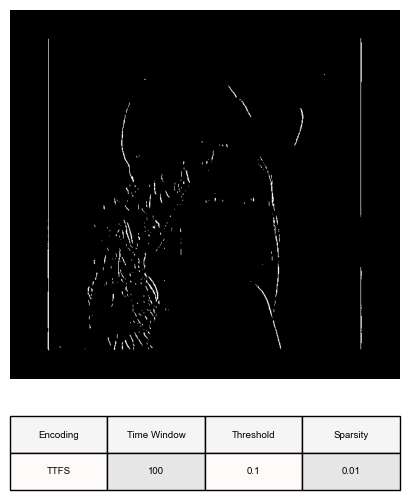

torch.Size([100, 609, 642])


In [7]:
# time to first spike of gabor
TIME_WINDOW = 100
THRESHOLD = 0.1
SPARSITY = 0.01

encoder = Intensity2Latency(time_window=TIME_WINDOW, threshold=THRESHOLD, sparsity=SPARSITY)
spikes_on_center = encoder(filtered_image_gabor)

plt.axis('off')
plt.imshow(spikes_on_center.sum(0), cmap="gray")

FONT = "arial"
parameters = ["Encoding","Time Window", "Threshold", "Sparsity"]
values = ["TTFS",TIME_WINDOW, THRESHOLD, SPARSITY]
table_data = [parameters, values]
table = plt.table(cellText = table_data, cellLoc = "center", loc = "bottom", bbox = [0, -0.3, 1, 0.2])
table.scale(0.8, 0.8)
table.set_fontsize(9)
for i in range(len(parameters)):
        table[(0, i)].set_facecolor("whitesmoke")
        table[(0, i)].set_text_props(color = 'black', fontfamily = FONT)

for i in range(len(values)):
        table[(1, i)].set_facecolor("snow" if i % 2 == 0 else '#e6e6e6')
        table[(1, i)].set_text_props(fontfamily = FONT)

plt.show()

print(spikes_on_center.shape)
# raster plot 3d 
fig = go.Figure(data=[go.Scatter3d(
    x=spikes_on_center.nonzero(as_tuple=True)[2],
    y=spikes_on_center.nonzero(as_tuple=True)[1],
    z=spikes_on_center.nonzero(as_tuple=True)[0],
    mode='markers',
    marker=dict(
        size=2,
        color='black',             
        colorscale='Viridis',   
        opacity=0.8
    )
)])

fig.update_layout(scene = dict(
                    xaxis_title='X',
                    yaxis_title='Y',
                    zaxis_title='Time'),
                    width=700,
                    margin=dict(r=20, l=10, b=10, t=10))
fig.show()

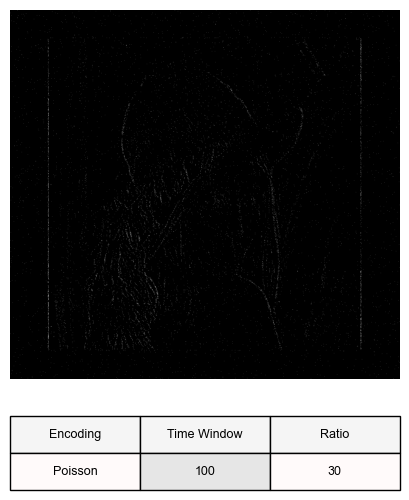

torch.Size([100, 609, 642])


In [8]:
# poisson gabor
TIME_WINDOW = 100
RATIO = 30

encoder = SimplePoisson(time_window=TIME_WINDOW, ratio=RATIO)
spikes_on_center = encoder(filtered_image_gabor/255.0)

plt.axis('off')
plt.imshow(spikes_on_center.sum(0), cmap="gray")

FONT = "arial"
parameters = ["Encoding","Time Window", "Ratio"]
values = ["Poisson",TIME_WINDOW, RATIO]
table_data = [parameters, values]
table = plt.table(cellText = table_data, cellLoc = "center", loc = "bottom", bbox = [0, -0.3, 1, 0.2])
table.scale(0.8, 0.8)
table.set_fontsize(9)
for i in range(len(parameters)):
        table[(0, i)].set_facecolor("whitesmoke")
        table[(0, i)].set_text_props(color = 'black', fontfamily = FONT)

for i in range(len(values)):
        table[(1, i)].set_facecolor("snow" if i % 2 == 0 else '#e6e6e6')
        table[(1, i)].set_text_props(fontfamily = FONT)
plt.show()

print(spikes_on_center.shape) 
# raster plot 3d 
fig = go.Figure(data=[go.Scatter3d(
    x=spikes_on_center.nonzero(as_tuple=True)[2],
    y=spikes_on_center.nonzero(as_tuple=True)[1],
    z=spikes_on_center.nonzero(as_tuple=True)[0],
    mode='markers',
    marker=dict(
        size=2,
        color='black',                
        colorscale='Viridis',   
        opacity=0.8
    )
)])

fig.update_layout(scene = dict(
                    xaxis_title='X',
                    yaxis_title='Y',
                    zaxis_title='Time'),
                    width=700,
                    margin=dict(r=20, l=10, b=10, t=10))
fig.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


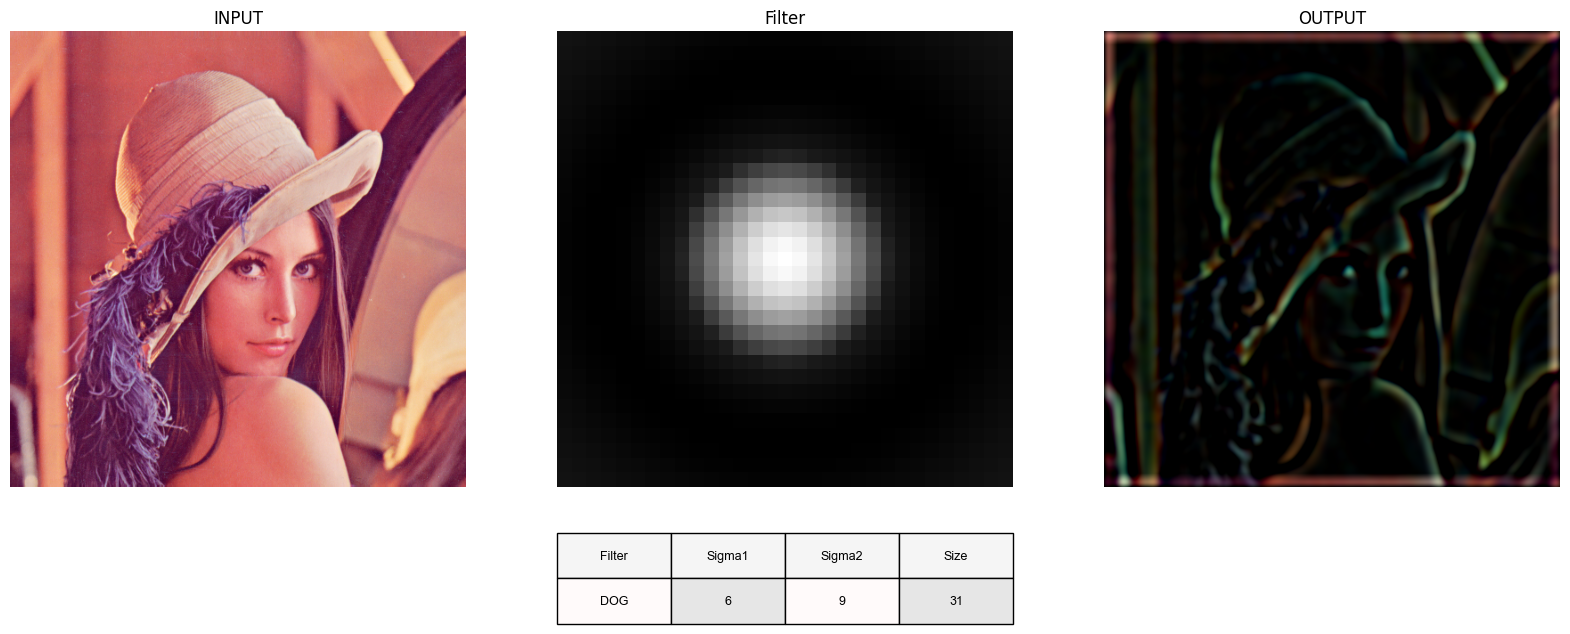

In [9]:
# DOG for color pictures
image = plt.imread("Lenna.jpg")
if image.shape[2] == 4:
    image = image[:, :, :3]
image = torch.tensor(image, dtype=torch.float32)
SIZE = 31
S1 = 6
S2 = 9

dog_filter = DoGFilter(size = SIZE, sigma_1 = S1, sigma_2 = S2,zero_mean=True, one_sum=False ,device="cpu", dtype=torch.float32)
# APPLY DOG FILTER TO EACH COLOR CHANNEL
filtered_image = torch.zeros_like(image)
for i in range(3):
    channel = image[:, :, i].unsqueeze(0).unsqueeze(0)
    channel = F.conv2d(channel, dog_filter.unsqueeze(0).unsqueeze(0), padding=SIZE//2)
    filtered_image[:, :, i] = channel.squeeze()


figure, axis = plt.subplots(1, 3, figsize=(20,20))
for ax in axis:
    ax.axis('off')
axis[2].imshow(filtered_image, cmap="gray")
axis[2].set_title("OUTPUT")
axis[1].imshow(dog_filter, cmap="gray")
axis[1].set_title("Filter")
axis[0].imshow(image)
axis[0].set_title("INPUT")
FONT = "arial"
parameters = ["Filter", "Sigma1", "Sigma2", "Size"]
values = ["DOG", S1, S2, SIZE]
table_data = [parameters, values]
table = axis[1].table(cellText = table_data, cellLoc = "center", loc = "bottom", bbox = [0, -0.3, 1, 0.2])
table.scale(0.8, 0.8)
table.auto_set_font_size(False)
table.set_fontsize(9)
for i in range(len(parameters)):
        table[(0, i)].set_facecolor("whitesmoke")
        table[(0, i)].set_text_props(color = 'black', fontfamily = FONT)

for i in range(len(values)):
        table[(1, i)].set_facecolor("snow" if i % 2 == 0 else '#e6e6e6')
        table[(1, i)].set_text_props(fontfamily = FONT)

plt.show()
